[ AiDALab 양석환 | NLP - 12 ]

---

- 참고도서
  - 파이토치 첫걸음 (최건호 : 한빛미디어)
  - 펭귄브로의 3분 딥러닝, 파이토치맛 (김건우, 염상준 : 한빛미디어)
  - 밑바닥부터 시작하는 딥러닝 2 (사이토 고키 / 개앞맵시 : 한빛미디어)

---

# **순환 신경망 (Recurrent Neural Network, RNN)**

In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)
DATA_PATH = "/gdrive/My Drive/Lectures/NLP/data/"

Mounted at /gdrive


In [ ]:
ROOT_PATH = "/gdrive/My Drive/Lectures/NLP/"

## Ⅰ.RNN

### 1.1 간단한 문자 처리 RNN

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [ ]:
# 하이퍼파라미터 설정

n_hidden = 35 
lr = 0.01
epochs = 1000

In [ ]:
# 사용하는 문자는 영어 소문자 및 몇가지 특수문자로 제한
# alphabet(0-25), space(26), ... , start(0), end(1)

string = "hello pytorch. how long can a rnn cell remember? show me your limit!"
chars =  "abcdefghijklmnopqrstuvwxyz ?!.,:;01"

# 문자들을 리스트로 바꾸고 길이(=문자의 개수) 저장
char_list = [i for i in chars]
n_letters = len(char_list)

In [ ]:
# 문자를 one-hot 벡터로 바꿔서 연산 수행

#Start = [0 0 0 … 1 0]
#a =     [1 0 0 … 0 0]
#b =     [0 1 0 … 0 0]
#c =     [0 0 1 … 0 0]
#...
#end =   [0 0 0 … 0 1]

In [ ]:
# 문자열을 one-hot 벡터의 스택으로 만드는 함수
# abc -> [[1 0 0 … 0 0],
#         [0 1 0 … 0 0],
#         [0 0 1 … 0 0]]

def string_to_onehot(string):
    # 먼저 시작 토큰과 끝 토큰 생성
    start = np.zeros(shape=n_letters ,dtype=int)
    end = np.zeros(shape=n_letters ,dtype=int)
    start[-2] = 1
    end[-1] = 1

    # 문자열의 문자들을 차례대로 받아서 진행
    for i in string:
        # 먼저 문자가 몇번째 문자인지 확인
        # a:0, b:1, c:2,...
        idx = char_list.index(i)

        # 0으로만 구성된 배열 생성
        # [0 0 0 … 0 0]
        zero = np.zeros(shape=n_letters ,dtype=int)

        # 해당 문자 인데스만 1로 지정
        # b: [0 1 0 … 0 0]
        zero[idx]=1

        # start와 새로 생긴 zero를 붙이고 이를 start에 할당
        # 이게 반복되면 start에는 문자를 one-hot 벡터로 바꾼 배열들이 점점 쌓이게 됨
        start = np.vstack([start,zero])

    # 문자열이 다 끝나면 쌓아온 start와 end를 결합
    output = np.vstack([start,end])
    return output

In [ ]:
# One-hot 벡터를 문자로 바꿔주는 함수 
# [1 0 0 ... 0 0] -> a 
# https://pytorch.org/docs/stable/tensors.html?highlight=numpy#torch.Tensor.numpy

def onehot_to_word(onehot_1):
    # 텐서를 입력으로 받아 넘파이 배열로 변경
    onehot = torch.Tensor.numpy(onehot_1)
    # one-hot 벡터의 최대값(=1) 위치 인덱스로 문자 검색
    return char_list[onehot.argmax()]

In [ ]:
# RNN with 1 hidden layer

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.act_fn = nn.Tanh()
    
    def forward(self, input, hidden):
        # 입력과 hidden state를 cat함수로 결합
        combined = torch.cat((input, hidden), 1)
        # 붙인 값을 i2h 및 i2o에 통과시켜 hidden state는 업데이트, 결과값은 계산
        hidden = self.act_fn(self.i2h(combined))
        output = self.i2o(combined)
        return output, hidden
    
    # 아직 입력이 없을때(t=0)의 hidden state를 초기화
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)    

In [ ]:
rnn = RNN(n_letters, n_hidden, n_letters)

In [ ]:
# 손실함수와 최적화함수 설정

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

In [ ]:
# train

# 문자열을 onehot 벡터로 만들고 이를 토치 텐서로 변경
# 데이터타입도 학습에 맞게 변경
one_hot = torch.from_numpy(string_to_onehot(string)).type_as(torch.FloatTensor())

for i in range(epochs):
    optimizer.zero_grad()
    # 학습에 앞서 hidden state 초기화
    hidden = rnn.init_hidden()
    
    # 문자열 전체에 대한 손실을 구하기 위해 total_loss라는 변수 생성
    total_loss = 0
    for j in range(one_hot.size()[0]-1):
        # 입력은 앞에 글자 
        # pyotrch 에서 p y t o r c
        input_ = one_hot[j:j+1,:]
        # 목표값은 뒤에 글자
        # pytorch 에서 y t o r c h
        target = one_hot[j+1]
        output, hidden = rnn.forward(input_, hidden)
        
        loss = loss_func(output.view(-1),target.view(-1))
        total_loss += loss

    total_loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(total_loss)

tensor(2.7046, grad_fn=<AddBackward0>)
tensor(1.1841, grad_fn=<AddBackward0>)
tensor(0.7267, grad_fn=<AddBackward0>)
tensor(0.4613, grad_fn=<AddBackward0>)
tensor(0.2882, grad_fn=<AddBackward0>)
tensor(0.1993, grad_fn=<AddBackward0>)
tensor(0.1411, grad_fn=<AddBackward0>)
tensor(0.1098, grad_fn=<AddBackward0>)
tensor(0.0940, grad_fn=<AddBackward0>)
tensor(0.0819, grad_fn=<AddBackward0>)
tensor(0.0735, grad_fn=<AddBackward0>)
tensor(0.0597, grad_fn=<AddBackward0>)
tensor(0.0516, grad_fn=<AddBackward0>)
tensor(0.0452, grad_fn=<AddBackward0>)
tensor(0.0416, grad_fn=<AddBackward0>)
tensor(0.0460, grad_fn=<AddBackward0>)
tensor(0.0362, grad_fn=<AddBackward0>)
tensor(0.0320, grad_fn=<AddBackward0>)
tensor(0.0286, grad_fn=<AddBackward0>)
tensor(0.0269, grad_fn=<AddBackward0>)
tensor(0.0263, grad_fn=<AddBackward0>)
tensor(0.0234, grad_fn=<AddBackward0>)
tensor(0.0226, grad_fn=<AddBackward0>)
tensor(0.0204, grad_fn=<AddBackward0>)
tensor(0.0216, grad_fn=<AddBackward0>)
tensor(0.0189, grad_fn=<A

In [ ]:
# test 
# hidden state 는 처음 한번만 초기화

start = torch.zeros(1,n_letters)
start[:,-2] = 1

with torch.no_grad():
    hidden = rnn.init_hidden()
    # 처음 입력으로 start token을 전달
    input_ = start

    # output string에 문자들을 계속 결합
    output_string = ""

    # 원래는 end token이 나올때 까지 반복하는게 맞으나 끝나지 않아서 string의 길이로 결정
    for i in range(len(string)):
        output, hidden = rnn.forward(input_, hidden)
        # 결과값을 문자로 바꿔서 output_string에 결합
        output_string += onehot_to_word(output.data)
        # 결과값은 다음의 입력값으로 적용
        input_ = output

print(output_string)

hello pytmrce eiemeremeiererei ieomr obceg pbem l peem rmbem rbeg pb


- "Hello PyT" 까지는 잘 생성했으나 그 뒤로는 무슨 말인지 모르겠음.
- 전체적인 데이터의 양, 학습 횟수 및 시간 등이 적기때문에 충분한 결과를 기대하기는 어려움.
- 더 많은 데이터와 학습이 필요함

### 1.2 RNN 기울기 폭발/소실 문제

[1.2342034047289652, 0.8339262435402592, 0.5979099219216478, 0.3924742082554759, 0.25252426453184545, 0.16017442237957719, 0.10106299614538984, 0.06358148956166684, 0.039950839098332, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595104, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571367, 0.0009625497320203268, 0.0006040924319556743, 0.00037912574706291117, 0.00023793756048323344]


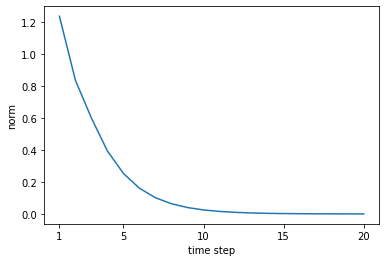

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3)   # 재현할 수 있도록 난수의 시드 고정

Wh = np.random.randn(H, H)
# Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
  dh = np.matmul(dh, Wh.T)
  norm = np.sqrt(np.sum(dh**2)) / N
  norm_list.append(norm)

print(norm_list)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()


## Ⅱ.RNN 활용 예제

### 2.1 영화 리뷰 감정 분석
- RNN 을 이용해 IMDB 데이터를 가지고 텍스트 감정분석을 해 보자.
<br><br>
- 텍스트 형태의 데이터셋인 IMDB 데이터셋은 50,000건의 영화 리뷰로 이루어져 있음.
- 각 리뷰는 다수의 영어 문장들로 이루어져 있으며, 
- 평점이 7점 이상의 긍정적인 영화 리뷰는 2로, 평점이 4점 이하인 부정적인 영화 리뷰는 1로 레이블링 되어 있음.
- 영화 리뷰 텍스트를 RNN 에 입력시켜 영화평의 전체 내용을 압축하고, 이렇게 압축된 리뷰가 긍정적인지 부정적인지 판단해주는 간단한 분류 모델을 만드는 것이 이번 프로젝트의 목표

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchtext import datasets        # 현재 버전에서 사라짐 torchtext --> torchtext.legacy 로 변경할 것
from torchtext.legacy import data, datasets

In [ ]:
# 하이퍼파라미터
BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", DEVICE)

다음 기기로 학습합니다: cpu


In [ ]:
TEXT = data.Field(sequential=True, batch_first=True, lower=True)
TEXT

In [ ]:
# 데이터 로딩하기
print("데이터 로딩중...")
TEXT = data.Field(sequential=True, batch_first=True, lower=True)
LABEL = data.Field(sequential=False, batch_first=True)
trainset, testset = datasets.IMDB.splits(TEXT, LABEL)
TEXT.build_vocab(trainset, min_freq=5)
LABEL.build_vocab(trainset)

# 학습용 데이터를 학습셋 80% 검증셋 20% 로 나누기
trainset, valset = trainset.split(split_ratio=0.8)
train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trainset, valset, testset), batch_size=BATCH_SIZE,
        shuffle=True, repeat=False)


vocab_size = len(TEXT.vocab)
n_classes = 2

데이터 로딩중...
downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:01<00:00, 45.6MB/s]


In [ ]:
print("[학습셋]: %d [검증셋]: %d [테스트셋]: %d [단어수]: %d [클래스] %d"
      % (len(trainset),len(valset), len(testset), vocab_size, n_classes))

[학습셋]: 20000 [검증셋]: 5000 [테스트셋]: 25000 [단어수]: 46159 [클래스] 2


In [ ]:
class BasicGRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(BasicGRU, self).__init__()
        print("Building Basic GRU model...")
        self.n_layers = n_layers
        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x):
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0))
        x, _ = self.gru(x, h_0)  # [i, b, h]
        h_t = x[:,-1,:]
        self.dropout(h_t)
        logit = self.out(h_t)  # [b, h] -> [b, o]
        return logit
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()


In [ ]:
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1)  # 레이블 값을 0과 1로 변환
        optimizer.zero_grad()

        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        optimizer.step()

In [ ]:
def evaluate(model, val_iter):
    """evaluate model"""
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1) # 레이블 값을 0과 1로 변환
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

In [ ]:
model = BasicGRU(1, 256, vocab_size, 128, n_classes, 0.5).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Building Basic GRU model...


- 아래의 코드는 GPU를 이용해서 실행할 것을 권장함.
- CPU 만으로 실행했을 경우 Epochs=10 의 설정에서 총 3시간 32분 42초 소요됨

In [ ]:
best_val_loss = None
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)

    print("[이폭: %d] 검증 오차:%5.2f | 검증 정확도:%5.2f" % (e, val_loss, val_accuracy))
    
    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), '{}snapshot/txtclassification.pt'.format(ROOT_PATH))
        best_val_loss = val_loss

[이폭: 1] 검증 오차: 0.70 | 검증 정확도:50.02
[이폭: 2] 검증 오차: 0.59 | 검증 정확도:70.24
[이폭: 3] 검증 오차: 0.40 | 검증 정확도:83.64
[이폭: 4] 검증 오차: 0.37 | 검증 정확도:83.92
[이폭: 5] 검증 오차: 0.33 | 검증 정확도:86.38
[이폭: 6] 검증 오차: 0.37 | 검증 정확도:85.88
[이폭: 7] 검증 오차: 0.46 | 검증 정확도:85.86
[이폭: 8] 검증 오차: 0.43 | 검증 정확도:86.82
[이폭: 9] 검증 오차: 0.50 | 검증 정확도:86.78
[이폭: 10] 검증 오차: 0.44 | 검증 정확도:86.14


- 테스트 수행 시간: 1분 33초(CPU)

In [ ]:
model.load_state_dict(torch.load('{}snapshot/txtclassification.pt'.format(ROOT_PATH)))
test_loss, test_acc = evaluate(model, test_iter)
print('테스트 오차: %5.2f | 테스트 정확도: %5.2f' % (test_loss, test_acc))

테스트 오차:  0.35 | 테스트 정확도: 85.06


## 6-2. Seq2Seq 기계 번역
- 단순화 된 Seq2Seq 모델 사용
- 한 언어로 된 문장을 다른 언어로 된 문장으로 번역하는 덩치가 큰 모델이 아닌 
- 영어 알파벳 문자열("hello")을 스페인어 알파벳 문자열("hola")로 번역하는 Mini Seq2Seq 모델 구현

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [2]:
vocab_size = 256  # 총 아스키 코드 개수
x_ = list(map(ord, "hello"))  # 아스키 코드 리스트로 변환
y_ = list(map(ord, "hola"))   # 아스키 코드 리스트로 변환
print("hello -> ", x_)
print("hola  -> ", y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [3]:
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

In [4]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        # 인코더에 들어갈 입력
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        # embedding = [seq_len, batch_size, embedding_size]
        
        # 인코더 (Encoder)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        # encoder_output = [seq_len, batch_size, hidden_size]
        # encoder_state  = [n_layers, seq_len, hidden_size]

        # 디코더에 들어갈 입력
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0])
        
        # 디코더 (Decoder)
        outputs = []
        
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            projection = self.project(decoder_output)
            outputs.append(projection)
            
            #티처 포싱(Teacher Forcing) 사용
            decoder_input = torch.LongTensor([targets[i]])

        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [5]:
seq2seq = Seq2Seq(vocab_size, 16)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)

In [7]:
log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n 반복:%d 오차: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


 반복:0 오차: 5.4707255363464355
['>', 'ú', '0', 'à']

 반복:100 오차: 1.8895719051361084
['h', 'o', 'l', 'a']

 반복:200 오차: 0.5699897408485413
['h', 'o', 'l', 'a']

 반복:300 오차: 0.3029702603816986
['h', 'o', 'l', 'a']

 반복:400 오차: 0.17270201444625854
['h', 'o', 'l', 'a']

 반복:500 오차: 0.11558175086975098
['h', 'o', 'l', 'a']

 반복:600 오차: 0.08464813232421875
['h', 'o', 'l', 'a']

 반복:700 오차: 0.0654199942946434
['h', 'o', 'l', 'a']

 반복:800 오차: 0.052417706698179245
['h', 'o', 'l', 'a']

 반복:900 오차: 0.043105315417051315
['h', 'o', 'l', 'a']


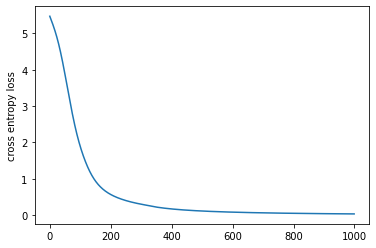

In [8]:
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()